<a href="https://colab.research.google.com/github/mkorlyakova/MSTU-courses/blob/main/ML%20magister/15/ML_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 7


Рекуррентные нейронные сети (RNN) — это класс нейронных сетей, которые хороши для моделирования последовательных данных, таких как временные ряды или естественный язык.

Если схематично, слой RNN использует цикл for для итерации по упорядоченной по времени последовательности, храня при этом во внутреннем состоянии, закодированную информацию о шагах, которые он уже видел.

Рекуррентные узлы:


1. tf.keras.layers.SimpleRNN, полносвязная RNN в которой выход предыдущего временного шага должен быть передан в следующий шаг.
2. tf.keras.layers.GRU,  Изучение представлений фраз с использованием кодера-декодера RNN для статистического машинного перевода
3. tf.keras.layers.LSTM, Долгая краткосрочная память

**Пример:**

model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))


- *Выходом GRU будет 3D тензор размера (batch_size, timesteps, 256)*



model.add(layers.GRU(256, return_sequences=True))


- *Выходом SimpleRNN будет 2D тензор размера (batch_size, 128)*


model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()


- Кроме того, слой RNN может вернуть свое конечное внутреннее состояние (состояния).

- Возвращенные состояния можно использовать позже для возобновления выполнения RNN или для инициализации другой RNN. Эта настройка обычно используется в модели энкодер-декодер, последовательность к последовательности, где итоговое состояние энкодера используется для начального состояния декодера.

- Для того чтобы слой RNN возвращал свое внутреннее состояние, установите параметр return_state в значение True при создании слоя. Обратите внимание, что у LSTM 2 тензора состояния, а у GRU только один.

- Чтобы настроить начальное состояние слоя, просто вызовите слой с дополнительным аргументом initial_state.

- Размерность должна совпадать с размерностью элемента слоя.





### **LSTM**

Long short term memory, LSTM -  представляет собой систему глубинного обучения, при реализации которой удалось обойти проблему исчезновения или взрыва градиентов в процессе обучения методом обратного распространения ошибки. 

Сеть LSTM обычно модерируется с помощью рекуррентных вентилей, которые называются вентили (gates) «забывания».


**Выходы и состояния**

- По умолчанию выход слоя RNN содержит один вектор на элемент. Этот вектор является выходом последней ячейки RNN, содержащей информацию обо всей входной последовательности. Размерность этого выхода (batch_size, units), где units соответствует аргументу units передаваемому конструктору слоя.

- Слой RNN может также возвращать всю последовательность выходных данных для каждого элемента (по одному вектору на каждый шаг), если вы укажете return_sequences=True. Размерность этих выходных данных равна (batch_size, timesteps, units).




## **Временные ряды**



In [243]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [244]:
import os
import datetime

In [245]:
from tensorflow.keras.callbacks import EarlyStopping

Читаем данные из файла со значениями (потребление энергии дневные отсчеты)

In [246]:
files.upload()


{}

In [392]:
#path = '/content/monthly-milk-production.csv'
#df = pd.read_csv(path, sep = ';')
#df.head()

In [394]:
#df = pd.read_csv('Brent2019.csv', index_col='Date')
df = pd.read_csv('/content/PJME_Потребление_энергии_D.csv', index_col='Date')

df.head()

,PJME_MW
Date,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0


Данные о потреблении энергии+ индексы (дата)

In [248]:
df.head()

,PJME_MW
Date,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0


Сортируем по дате

In [249]:


df.sort_index(ascending=True, inplace=True)
df.head()

,PJME_MW
Date,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0



Для PJME  все лишнее уже отбросили

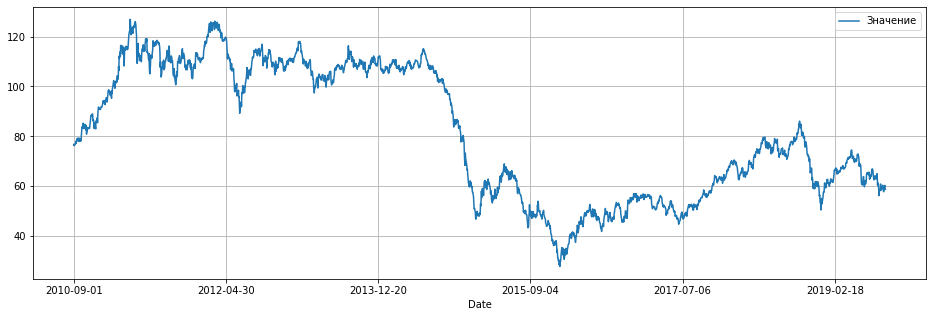

In [359]:
df.plot( figsize = (16,5))
#df['PJME_MW'].plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [360]:
df.describe()

,Значение
count,2667.000000
mean,81.533547
std,26.349469
min,27.850000
25%,56.840000
50%,77.710000
75%,108.190000
max,126.900000


Добавим дату как признаки:
как "день в году"/366 и (год-2002)

In [361]:
df['day'] = pd.to_datetime(df.index).dayofyear/366.0
df['year'] = pd.to_datetime(df.index).year - 2002
df.head()

,Значение,day,year
Date,,,
2010-09-01,76.37,0.666667,8
2010-09-02,76.89,0.669399,8
2010-09-03,76.57,0.672131,8
2010-09-04,76.62,0.674863,8
2010-09-05,76.63,0.677596,8


In [362]:
#
data = df.copy() # берем все что есть

In [363]:
data.head()

,Значение,day,year
Date,,,
2010-09-01,76.37,0.666667,8
2010-09-02,76.89,0.669399,8
2010-09-03,76.57,0.672131,8
2010-09-04,76.62,0.674863,8
2010-09-05,76.63,0.677596,8


Делаем нормализацию

In [364]:
def normalize(data, data_mean = 0,data_std= 0 ):
    
    if data_std == 0:
      data_mean = data.mean(axis = 0)
      data_std = data.std(axis = 0)
    return (data - data_mean) / data_std, data_mean,data_std

Можно (и нужно заменять на sklearn StandadScaler) т.к. это нужно дополнительно сохранять для обработки реальных данных , но тут сделаем без привлечения внешних модулей

In [365]:
train_split = 1500

_,d_m,d_s =  normalize(data.iloc[:train_split,0].values)
data.iloc[:, 0] = (data.iloc[:, 0].values - d_m) / d_s

In [366]:
data.head()

,Значение,day,year
Date,,,
2010-09-01,-1.194457,0.666667,8
2010-09-02,-1.167723,0.669399,8
2010-09-03,-1.184175,0.672131,8
2010-09-04,-1.181604,0.674863,8
2010-09-05,-1.181090,0.677596,8


Создаем данные для обучения

In [367]:
# список признаков, по которым будем учить
#channelIndexes = [0,1, 2, 3] # BRENT
channelIndexes = [0,1,2]

# длина теста
valLen = 100
# длина истории для работы
xLen = 14
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку

# делим
train_data = data.iloc[0 : train_split ,channelIndexes]
val_data = data.iloc[train_split+bias:,channelIndexes]



In [368]:
train_data.head(3)

,Значение,day,year
Date,,,
2010-09-01,-1.194457,0.666667,8
2010-09-02,-1.167723,0.669399,8
2010-09-03,-1.184175,0.672131,8


Формируем параметры для генерации выборки

In [369]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.0005
batch_size = 32
epochs = 50


Выделяем части на обучение и проверку по правилам временных рядов:

In [370]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)




In [371]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(1486, 3)
(1486,)
(1143, 3)
(1143,)


Посмотрим на них

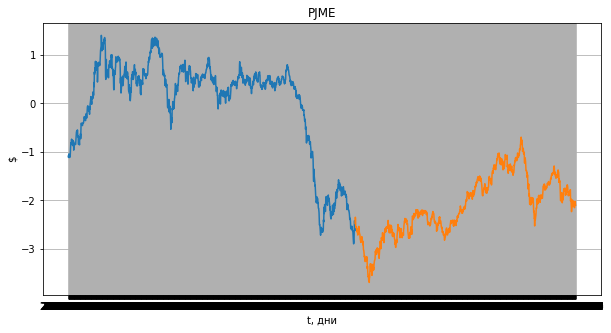

In [372]:
plt.figure(figsize = (10,5))
plt.plot(data.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid()
plt.xlabel('t, дни')
plt.ylabel('$')
#plt.title('стоимость BRENT в 2010-2018')
plt.title('PJME')
plt.show()

Используем механизм формирования пакетов для обучения

In [373]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length = xLen,
    sampling_rate = 1,
    batch_size = batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length = xLen,
    sampling_rate = 1,
    batch_size = batch_size,
)


Проверим , что все верно (для Х[i,xLen, :] y[i] - необходимо контролировать, что Х[i,xLen,0] не входит y[i])

In [374]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 14, 3)
Target shape: (32,)


In [375]:
inputs[1,0,:]

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([-2.53374017,  0.84153005, 13.        ])>

In [376]:
inputs[1,:,0]

<tf.Tensor: shape=(14,), dtype=float64, numpy=
array([-2.53374017, -2.61599939, -2.63964892, -2.66072785, -2.68694798,
       -2.6926033 , -2.71059751, -2.79542734, -2.80828034, -2.82473218,
       -2.86380532, -2.83295811, -2.84272639, -2.84786759])>

In [377]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-2.84786759273899>

In [378]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 14, 3)
Target shape: (32,)


In [379]:
inputs[0,:,0]

<tf.Tensor: shape=(14,), dtype=float64, numpy=
array([-0.84794012, -0.79241514, -0.78521746, -0.82994591, -0.83354475,
       -0.75899733, -0.80115518, -0.86593432, -0.87827321, -0.78470334,
       -0.9620748 , -0.82017763, -0.90295098, -0.85873664])>

In [380]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-0.8561660392456478>

**сеть:  LSTM слои+Conv1D +Dense слой.**

Epoch 1/50
47/47 [==============================] - 4s 30ms/step - loss: 0.8637 - mae: 0.6302 - val_loss: 0.7528 - val_mae: 0.7185
Epoch 2/50
47/47 [==============================] - 1s 15ms/step - loss: 1.1677 - mae: 0.7745 - val_loss: 1.0728 - val_mae: 0.8819
Epoch 3/50
47/47 [==============================] - 1s 15ms/step - loss: 1.1564 - mae: 0.7651 - val_loss: 1.0357 - val_mae: 0.8624
Epoch 4/50
47/47 [==============================] - 1s 14ms/step - loss: 1.2155 - mae: 0.7717 - val_loss: 3.5965 - val_mae: 1.7870
Epoch 5/50
47/47 [==============================] - 1s 14ms/step - loss: 0.9494 - mae: 0.6973 - val_loss: 3.0352 - val_mae: 1.6498
Epoch 6/50
47/47 [==============================] - 1s 15ms/step - loss: 0.4299 - mae: 0.4987 - val_loss: 0.8524 - val_mae: 0.8750


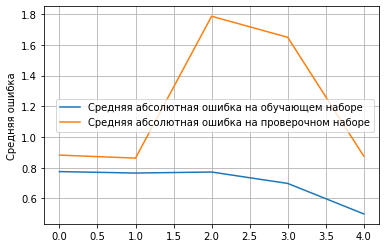

In [381]:
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences = "True")) # <None, 3,32>
model.add(Conv1D(64, 3, activation = "linear")) #(None,3,64)

model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation = "linear"))      # (None,3)

model.add(Dense(1, activation = "linear"))

model.compile(loss = "mse", optimizer = "adam", metrics = ['mae'])

history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_val,
    callbacks = [callbaсk])


plt.plot(history.history['mae'][1:], 
         label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.grid()
plt.legend()
plt.show()

In [382]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [383]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

36/36 [==============================] - 0s 6ms/step


Валидация:

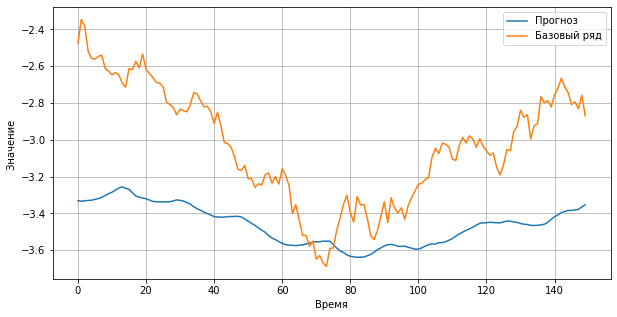

In [384]:
start = 0
step = 150
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label = 'Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label = 'Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Тренировочные даннные:

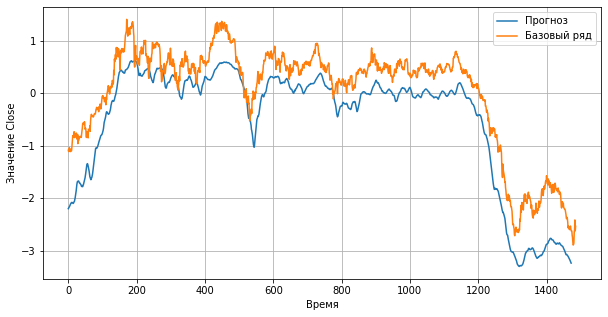

In [385]:
start = 0


plt.figure(figsize = (10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label = 'Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label = 'Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Проверяем качество модели:
- оценим по лаговой корреляции рядов a, b;
- если наибольшая корреляция с лагом 0, то отлично;
- есди максимум корреляциии на лаге , равном глубине прогноза, то тривиальное предсказание (завтра, как сегодня).


In [386]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

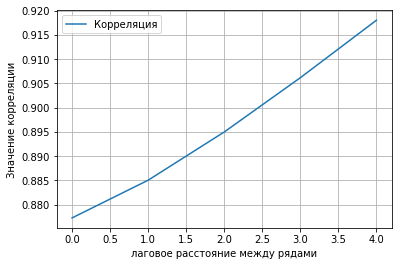

In [387]:
corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 150 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label = 'Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.grid()
plt.legend()
plt.show()

Хорошая картинки лаговой корреляции ряда yValF[:-i], yPredVal[i:]

In [388]:
corr

[0.8772440685948191,
 0.8850214405464563,
 0.8949646784652312,
 0.9061568185202231,
 0.918013638138839]

## **Дополнительные материалы**
простой ресурс про методы для работы с временными рядами

http://statsoft.ru/home/textbook/modules/sttimser.html


Анализ временных рядов 

https://habr.com/ru/company/ods/blog/327242/

Задание 1

  - Использовать данные PJME_Потребление_энергии_D.csv и провести генерацию в модели из примера.
  - Провести генерацию для данных Brent2019.csv
  - Сравнить результаты: провести анализ успешности генерации модели Brent2019.csv в сравнении с PJME_Потребление_энергии_D.csv. 

  - загрузить набор данных monthly-milk-production.csv
  - собрать данные для анализа временного ряда с горизонтом прогноза 1 месяц вперед
  - разделить данные по правилам временных рядов
  - собрать модель для анализа (в составе LSTM, ConvD1, Dense - слоев )
  - оценить влияние длины истории (xLen = 2 , 6, 12)
  - оценить изменение качества предсказания от ширины сети (3 вариации)

In [342]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import tensorflow.keras as keras 
import numpy as np 

from tensorflow.keras.callbacks import EarlyStopping

Разбор текста - Токенизация


In [ ]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(  num_words=10000)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

--2022-12-15 19:40:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.48, 142.251.111.128, 172.217.13.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2022-12-15 19:40:40 (128 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [ ]:
corpus[:10]

['from fairest creatures we desire increase,',
 "that thereby beauty's rose might never die,",
 'but as the riper should by time decease,',
 'his tender heir might bear his memory:',
 'but thou, contracted to thine own bright eyes,',
 "feed'st thy light'st flame with self-substantial fuel,",
 'making a famine where abundance lies,',
 'thyself thy foe, to thy sweet self too cruel.',
 "thou that art now the world's fresh ornament",
 'and only herald to the gaudy spring,']

Исполним токенизацию и кодирование

In [ ]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
token_list

[]

In [ ]:
tokenizer.index_word[14]

'love'

In [ ]:
tokenizer.word_index['love']

14

In [ ]:
input_sequences[11:15,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,   0,   0,   0,  16,  22,   2, 879,  61]],
      dtype=int32)

In [ ]:
label.shape

(15462, 3211)

Создаем сеть

In [ ]:
callback = EarlyStopping( monitor = 'val_accuracy', patience = 10) # создаем обратный вызов - calback - тут "Ранний останов"

In [ ]:
latent_dim = 128 # размер вектора эмбединга

latent_lstm = 256 # размер рекуррентного слоя 

lr = 0.001 # скорость обучения

In [ ]:
model = Sequential()
model.add(Embedding(total_words, latent_dim, input_length = max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(latent_lstm ))
model.add(Dropout( 0.2))
model.add(Dense(total_words // 2, activation = 'relu', kernel_regularizer = regularizers.l2(0.1)))
model.add(Dense(total_words, activation = 'softmax'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                             decay_steps=500,decay_rate=0.9)

model.compile(loss = CategoricalCrossentropy(from_logits=False), optimizer = Adam(learning_rate=lr_schedule ), metrics = ['accuracy'])
print(model.summary())


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 10, 128)           411008    
                                                                 
 lstm_37 (LSTM)              (None, 256)               394240    
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 dense_74 (Dense)            (None, 1605)              412485    
                                                                 
 dense_75 (Dense)            (None, 3211)              5156866   
                                                                 
Total params: 6,374,599
Trainable params: 6,374,599
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
387/387 [==============================] - 5s 8ms/step - loss: 8.6905 - accuracy: 0.0226 - val_loss: 6.7345 - val_accuracy: 0.0162
Epoch 2/100
387/387 [==============================] - 3s 8ms/step - loss: 6.5207 - accuracy: 0.0244 - val_loss: 6.8450 - val_accuracy: 0.0162
Epoch 3/100
387/387 [==============================] - 3s 7ms/step - loss: 6.4280 - accuracy: 0.0253 - val_loss: 6.9759 - val_accuracy: 0.0162
Epoch 4/100
387/387 [==============================] - 3s 8ms/step - loss: 6.3611 - accuracy: 0.0257 - val_loss: 7.0601 - val_accuracy: 0.0162
Epoch 5/100
387/387 [==============================] - 3s 7ms/step - loss: 6.3079 - accuracy: 0.0275 - val_loss: 7.1273 - val_accuracy: 0.0168
Epoch 6/100
387/387 [==============================] - 3s 7ms/step - loss: 6.2616 - accuracy: 0.0334 - val_loss: 7.1789 - val_accuracy: 0.0213
Epoch 7/100
387/387 [==============================] - 3s 7ms/step - loss: 6.2122 - accuracy: 0.0354 - val_loss: 7.2248 - val_accuracy: 0.0210

Тест


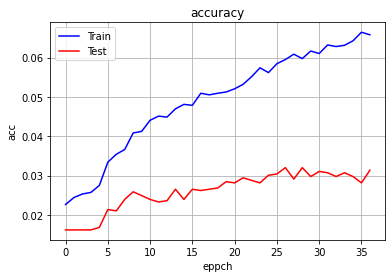

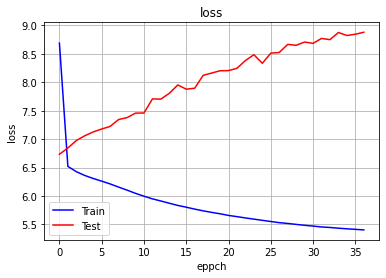

In [221]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')
plt.xlabel('eppch')
plt.ylabel('acc')
plt.grid()
plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.xlabel('eppch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

Строим тест генератора

In [230]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#начальная последовательность
next_words = 15 # число генераций
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0] #преобразование текущей строки
  print(token_list)
  token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  y_p = model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1])) # равномерный случайный выбор * сетевой выбор
  #выбор наиболее вероятного слова с вероятностью от сети
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[591, 18, 5, 352, 393]
1/1 [==============================] - 0s 17ms/step
[591, 18, 5, 352, 393, 3]
1/1 [==============================] - 0s 15ms/step
[591, 18, 5, 352, 393, 3, 48]
1/1 [==============================] - 0s 16ms/step
[591, 18, 5, 352, 393, 3, 48, 4]
1/1 [==============================] - 0s 18ms/step
[591, 18, 5, 352, 393, 3, 48, 4, 14]
1/1 [==============================] - 0s 18ms/step
[591, 18, 5, 352, 393, 3, 48, 4, 14, 7]
1/1 [==============================] - 0s 17ms/step
[591, 18, 5, 352, 393, 3, 48, 4, 14, 7, 101]
1/1 [==============================] - 0s 15ms/step
[591, 18, 5, 352, 393, 3, 48, 4, 14, 7, 101, 14]
1/1 [==============================] - 0s 17ms/step
[591, 18, 5, 352, 393, 3, 48, 4, 14, 7, 101, 14, 14]
1/1 [==============================] - 0s 14ms/step
[591, 18, 5, 352, 393, 3, 48, 4, 14, 7, 101, 14, 14, 21]
1/1 [==============================] - 0s 21ms/step
[591, 18, 5, 352, 393, 3, 48, 4, 14, 7, 101, 14, 14, 21, 53]
1/1 [=====================

Помоги мне, Оби Ван Кеноби, ты моя единственная надежда на время любви в любви любви, любовь, глаза, я, ты, я.

Получим предсказание для последнего token_list:

In [238]:
token_list

array([[  7, 101,  14,  14,  21,  53,   6,  24,   6,  21]], dtype=int32)

In [231]:
y_p=model.predict(token_list)

1/1 [==============================] - 0s 19ms/step


Отобразим вероятности слов:

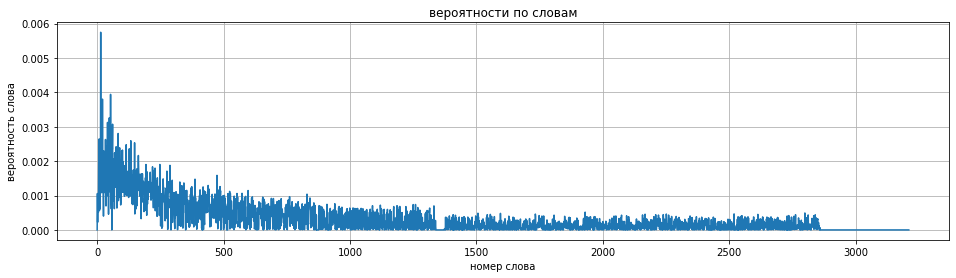

In [239]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

Список наиболее вероятных слов:

In [240]:
ind_prob=np.where(y_p[0,:]>0.00351)[0]
ind_prob

array([14, 21, 53])

In [237]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

love  :  0.0057478677
be  :  0.0038025023
eyes  :  0.0039414824


Help me Obi Wan Kenobi, you're my only hope by ill pen ' ' be gone into my sight and end truth quite unrespected

Помоги мне, Оби-Ван Кеноби, ты моя единственная надежда из-за плохого пера исчезнуть в моих глазах и покончить с правдой совершенно неуважительно


Задание 2

- Запустить примеры из Генератор_текста.
- Провести изменение моделей:
 - использовать 1 LSTM слой + 2 Dense (изменяем число ядер LSTM (использовать число ядер LSTM: latent_lstm = 128, 256, 512 ))
 - использовать 1 LSTM слой + 2 Dense (изменяем размер эмбединга : latent_dim = 64, 128, 256)
- Оценить результаты по одинаковой метрике (accuracy) 
- Провести генерацию от нескольких начальных состояний (3-5 начальных фраз) и определить как быстро происходит зацикливание (начинает повторяться текст). Длину генерации выбрать 25-30 слов. 
